# Background
this piece of code read the model's outputs, store them into dictionaries and pandas DataFrames, and display graphs to show the model's results. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

regions = ('LONG', 'LAV', 'CN', 'CS', 'MTL')
other_regions = ('LAV', 'CN', 'CS', 'MTL')
urban_forms = ('CV', 'BF', 'BM', 'BD', 'IND', 'AGR')
energy_technologies = ('IMPE', 'IMPP', 'IMPGN', 'IMPBIO', 'IMPA')
fuels = ('E', 'P', 'GN', 'BIO', 'A')
years = list(range(2015, 2035))
modeling_period = len(years)

this function converts all data in a dataframe into numeric values.

In [2]:
def to_num(input_df):
    for col in input_df.columns:
        input_df[col] = pd.to_numeric(input_df[col])

this function organise an imported dataframe into a dictionary 

In [3]:
def sort_df_into_dic(input_df):

    output_dic={}

    output_dic['LONG']=input_df[:modeling_period + 1].set_index('Year')

    for reg in other_regions:
        ind = input_df[input_df['Year'] == reg].index[0]
        output_dic[reg] = input_df[ind + 1:ind + modeling_period + 2].set_index('Year')

    return output_dic

# Importing accumulated technology gain

In [4]:
acc_tech_gain_csv = pd.read_csv('accumulated_tech_gain.csv')
acc_tech_gain_csv.rename(columns={'LONG': 'Year'}, inplace=True)

acc_tech_gain = sort_df_into_dic(acc_tech_gain_csv)

for r in regions:
    acc_tech_gain[r] = acc_tech_gain[r].loc[:, urban_forms]

for reg in regions:
    to_num(acc_tech_gain[reg])

# Importing accumulated technology loss

In [5]:
acc_tech_loss_csv = pd.read_csv('accumulated_tech_loss.csv')
acc_tech_loss_csv.rename(columns={'LONG': 'Year'}, inplace=True)

acc_tech_loss = sort_df_into_dic(acc_tech_loss_csv)

for r in regions:
    acc_tech_loss[r] = acc_tech_loss[r].loc[:, urban_forms]

for reg in regions:
    to_num(acc_tech_loss[reg])

# Capacity conversion
from acc_tech_gain and acc_tech_loss we create a dict of dataframe containing accumulated technology capacity conversion for every region, urban form technology and year.  

In [6]:
capacity_conversion = {}

for r in regions:
    capacity_conversion[r] = pd.DataFrame()

for r in regions:
    for uf in urban_forms:
        capacity_conversion[r][uf] = acc_tech_gain[r][uf] - acc_tech_loss[r][uf]

# Importing emission

In [7]:
emission_csv = pd.read_csv('emission.csv')
emission_csv.rename(columns={'CO2': 'Year'}, inplace=True)
emission = emission_csv.set_index('Year')


# Importing total activity annual

In [8]:
total_activity_annual_csv = pd.read_csv('total_activity_annual.csv')
total_activity_annual_csv.rename(columns={'LONG': 'Year'}, inplace=True)

total_activity_annual = sort_df_into_dic(total_activity_annual_csv)

for reg in regions:
    to_num(total_activity_annual[reg])

summing the total annual activity over the regions
  


In [9]:
total_activity_annual_cmm = pd.DataFrame()

for uf in urban_forms:
        total_activity_annual_cmm[uf] = sum(total_activity_annual[reg][uf] for reg in regions)

# importing total capacity annual

In [10]:
total_capacity_annual_csv = pd.read_csv('total_capacity_annual.csv')
total_capacity_annual_csv.rename(columns={'LONG': 'Year'}, inplace=True)

total_capacity_annual = sort_df_into_dic(total_capacity_annual_csv)

for reg in regions:
    to_num(total_capacity_annual[reg])

summing the total annual capacity over the regions

In [11]:
total_capacity_annual_cmm = pd.DataFrame()

for uf in urban_forms:
    total_capacity_annual_cmm[uf] = sum(total_capacity_annual[reg][uf] for reg in regions)

# Importing production
first, we split the data per region

In [12]:
production_csv = pd.read_csv('production.csv')
production_csv.rename(columns={'LONG / CV': 'Year'}, inplace=True)

prod = {}
prod['LONG'] = production_csv[:263]
other_regions = ('LAV', 'CN', 'CS', 'MTL')
for r in other_regions:
    ind = production_csv[production_csv['Year'] == r + ' / CV'].index[0]
    prod[r] = production_csv[ind + 1:ind + 264].reset_index(drop=True)

If you look at the data stored in the prod dictionary you'll notice that a lot of rows are 0. It's because every technology produces one and only one fuel. this function keeps only the relevant columns for each technology and stores the result into a new data frame. 

In [13]:
def sort_prod(input_df):
        technologies = {
                    'BF': 'HOU',
                    'BM': 'HOU',
                    'BD': 'HOU',
                    'IND': 'HOU', 
                    'AGR': 'HOU', 
                    'DUMMYHOUSE': 'HOU', 
                    'IMPE': 'E', 
                    'IMPP': 'P', 
                    'IMPGN': 'GN',
                    'IMPBIO': 'BIO',
                    'IMPA': 'A'
                    }
        df = pd.DataFrame({'Year': input_df['Year'][:21], 'CV': input_df['HOU'][:21]})
        for tech in technologies:
            ind = input_df[input_df['Year'] == tech].index[0]
            df[tech] = input_df[technologies[tech]][ind + 1:ind + 22].values
            output_df = df.set_index('Year')
        return output_df

In [14]:
production = {}
for reg in prod:
    production[reg] = sort_prod(prod[reg])

for reg in regions:
    to_num(production[reg])

# plotting activity and capacity of urban forms

In [15]:
colors = {
    'CV': 'r',
    'BF': 'y',
    'BM': 'm',
    'BD': 'c',
    'IND': 'b',
    'AGR': 'g'
}

this piece of code plot the total annual activity and capacity in the CMM (With and without the AGR urban form)

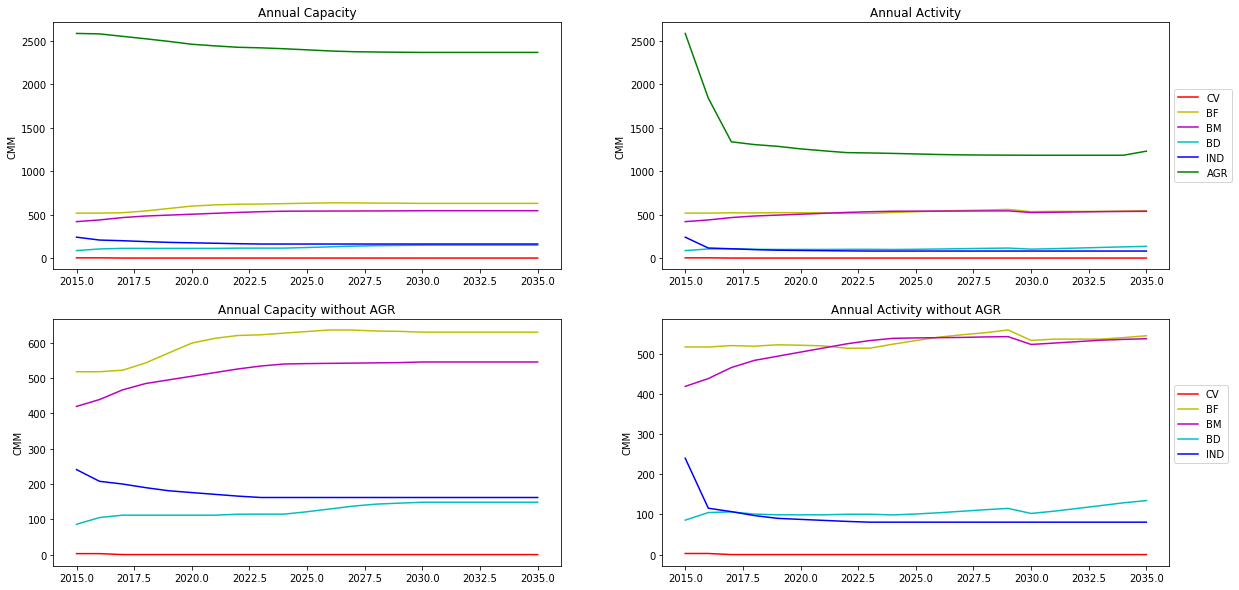

In [16]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for uf in urban_forms:

    ax1.plot(total_capacity_annual_cmm.index, total_capacity_annual_cmm[uf], c=colors[uf])
    ax1.set_title('Annual Capacity')
    ax1.set_ylabel('CMM')

    ax2.plot(total_activity_annual_cmm.index, total_activity_annual_cmm[uf], c=colors[uf])
    ax2.set_title('Annual Activity')
    ax2.legend(bbox_to_anchor=(1, 0.75))
    ax2.set_ylabel('CMM')

for uf in ('CV', 'BF', 'BM', 'BD', 'IND'):

    ax3.plot(total_capacity_annual_cmm.index, total_capacity_annual_cmm[uf], c=colors[uf])
    ax3.set_title('Annual Capacity without AGR')
    ax3.set_ylabel('CMM')

    ax4.plot(total_activity_annual_cmm.index, total_activity_annual_cmm[uf], c=colors[uf])
    ax4.set_title('Annual Activity without AGR')
    ax4.legend(bbox_to_anchor=(1.125, 0.75))
    ax4.set_ylabel('CMM')

plt.show()

this piece of code plot the total annual activity and total annual capacity of urban forms technologies for every region

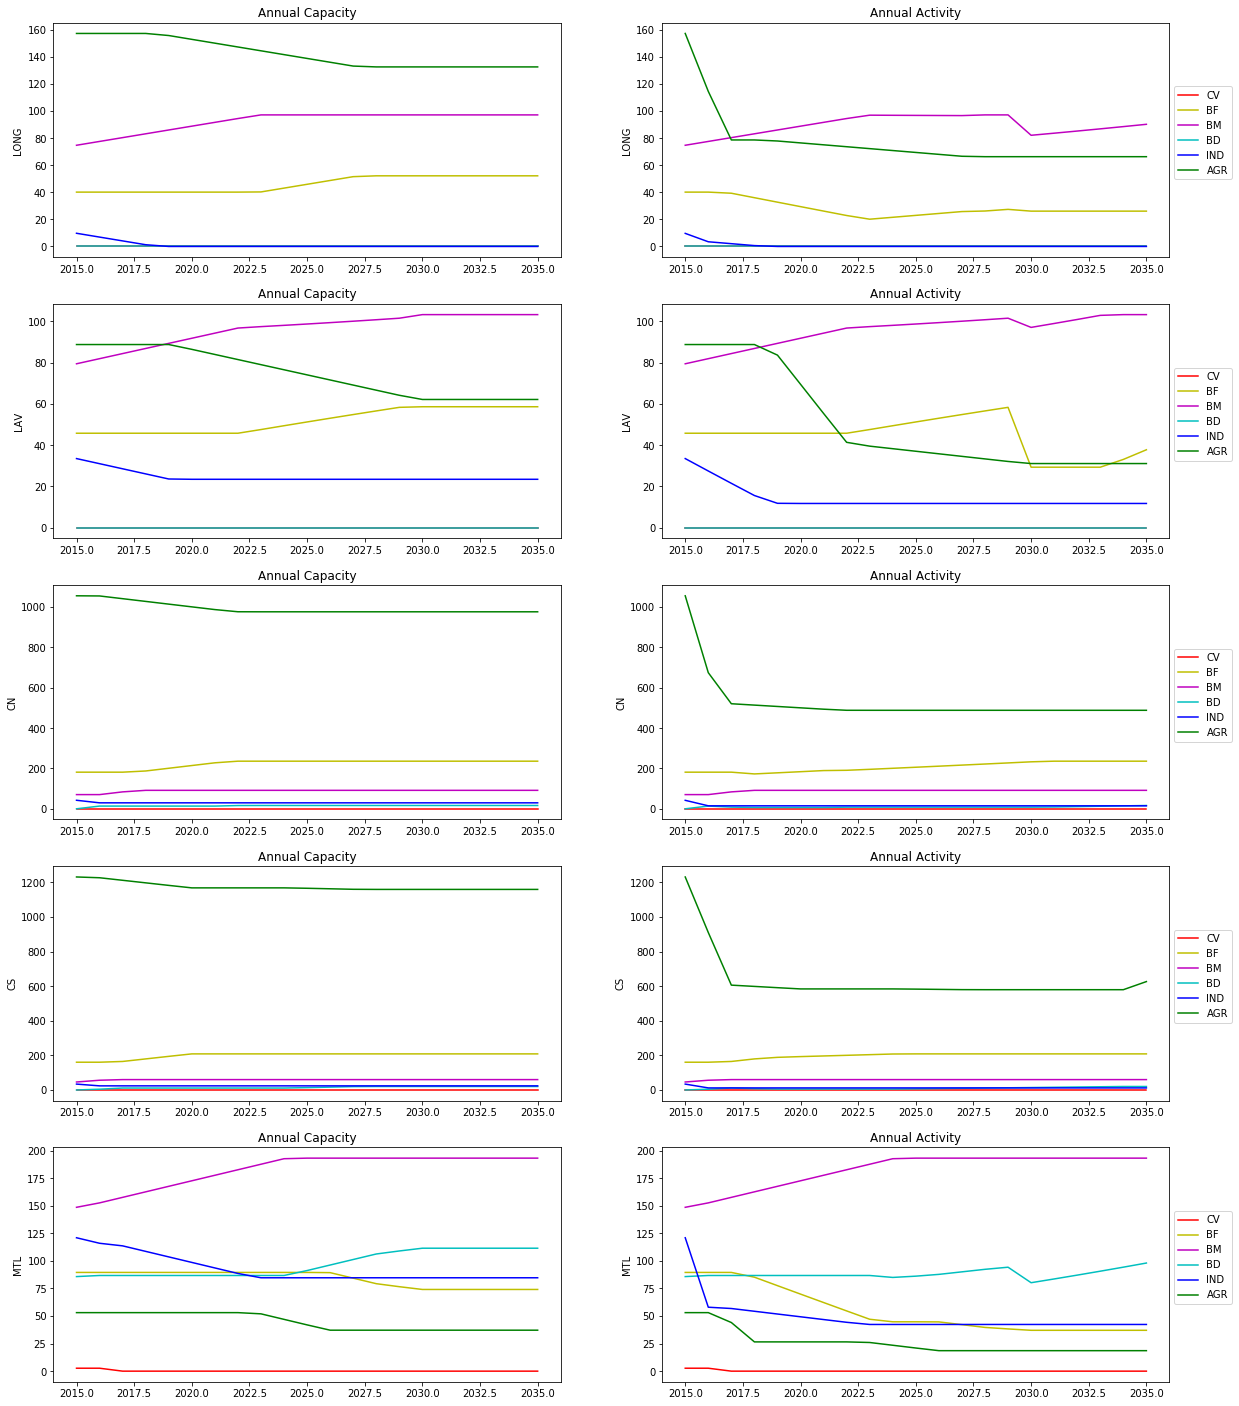

In [17]:
fig = plt.figure(figsize=(20, 25))

for i, reg in enumerate(regions):
    ax1 = fig.add_subplot(5, 2, 2 * i + 1)
    ax2 = fig.add_subplot(5, 2, 2 * i + 2)
    for uf in urban_forms:
        ax1.plot(total_capacity_annual[reg].index, total_capacity_annual[reg][uf], c=colors[uf])
        ax1.set_title('Annual Capacity')
        ax1.set_ylabel(reg)

    for uf in urban_forms:
        ax2.plot(total_activity_annual[reg].index, total_activity_annual[reg][uf], c=colors[uf])
        ax2.set_title('Annual Activity')
        ax2.set_ylabel(reg)
        ax2.legend(bbox_to_anchor=(1, 0.75))

plt.show()

# plotting capacity conversion
this piece of code shows the accumulated technology capacity conversion. You can see what are the choices of the model in converting urban form technologies.

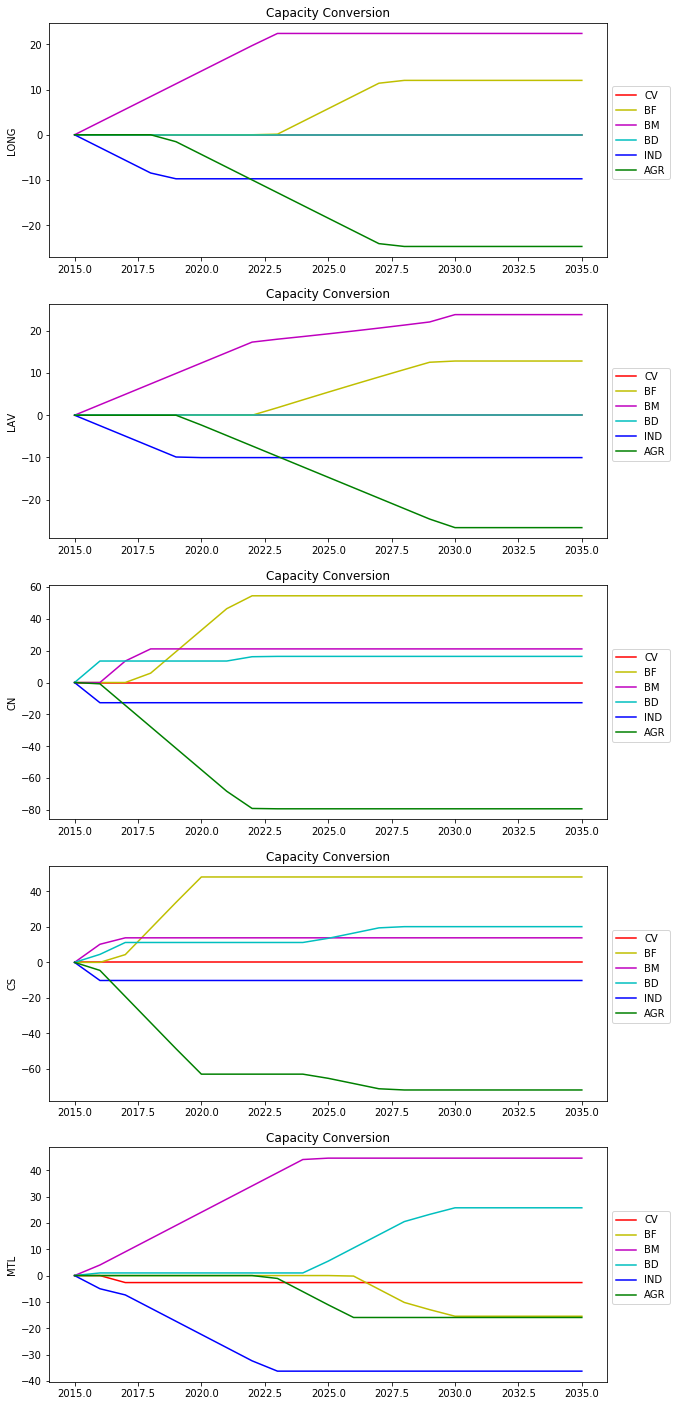

In [18]:
fig = plt.figure(figsize=(10, 25))

for i, reg in enumerate(regions):
    ax1 = fig.add_subplot(5, 1, i + 1)
    for uf in urban_forms:
        ax1.plot(capacity_conversion[reg].index, capacity_conversion[reg][uf], c=colors[uf])
        ax1.set_title('Capacity Conversion')
        ax1.set_ylabel(reg)
        ax1.legend(bbox_to_anchor=(1, 0.75))

plt.show()